In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `aya` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `aya`


In [ ]:
! pip install transformers sentence-transformers faiss-cpu accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/cl_json.json", "r", encoding="utf-8") as f:
    data = json.load(f)

qa_pairs = []
instructions = []
for category, content in data.items():
    if isinstance(content, list):
        for entry in content:
            if isinstance(entry, dict) and "Q" in entry and "A" in entry:
                answer_text = entry["A"]
                if isinstance(answer_text, list):
                    answer_text = " ".join(answer_text)
                qa_pairs.append((entry["Q"], answer_text))
            elif isinstance(entry, dict) and "question" in entry and "answer" in entry:
                answer_text = entry["answer"]
                if isinstance(answer_text, list):
                    answer_text = " ".join(answer_text)
                qa_pairs.append((entry["question"], answer_text))
            elif isinstance(entry, list):
                for sub_entry in entry:
                    if isinstance(sub_entry, dict) and "question" in sub_entry and "answer" in sub_entry:
                        answer_text = sub_entry["answer"]
                        if isinstance(answer_text, list):
                            answer_text = " ".join(answer_text)
                        qa_pairs.append((sub_entry["question"], answer_text))
            else:
                instructions.append(str(entry))
    elif isinstance(content, dict):
        for key, value in content.items():
            if isinstance(value, dict) and "question" in value and "answer" in value:
                answer_text = value["answer"]
                if isinstance(answer_text, list):
                    answer_text = " ".join(answer_text)
                qa_pairs.append((value["question"], answer_text))
            elif isinstance(value, list):
                instructions.extend(value)
            else:
                instructions.append(str(value))

print(f"Loaded {len(qa_pairs)} Q&A pairs and {len(instructions)} instructions.")


Loaded 6174 Q&A pairs and 612 instructions.


In [ ]:

import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
question_embeddings = embedder.encode([q[0] for q in qa_pairs])
instruction_embeddings = embedder.encode(instructions)

dimension = question_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(question_embeddings))
faiss_index.add(np.array(instruction_embeddings))
all_data = qa_pairs + [(inst, inst) for inst in instructions]

print(f"FAISS index built with {len(all_data)} entries")

instruction_text = " ".join(instructions)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS index built with 6786 entries


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("CohereForAI/aya-expanse-8b",timeout=600)
model = AutoModelForCausalLM.from_pretrained(
    "CohereForAI/aya-expanse-8b", load_in_4bit=True, device_map="auto"
)
text_gen_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

print("Model and pipeline loaded successfully!")


tokenizer_config.json:   0%|          | 0.00/8.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Device set to use cuda:0


Model and pipeline loaded successfully!


In [ ]:
def retrieve_answer(user_question, top_k=1):
    """Retrieve the closest matching answer from FAISS, including instructions and Q&A pairs."""
    user_embedding = embedder.encode([user_question])
    _, indices = faiss_index.search(np.array(user_embedding), top_k)

    retrieved_answers = []
    for idx in indices[0]:
        if 0 <= idx < len(qa_pairs):
            # Retrieve from Q&A pairs
            retrieved_answers.append(qa_pairs[idx][1])
        elif len(qa_pairs) <= idx < len(all_data):
            # Retrieve from instructions
            retrieved_answers.append(all_data[idx][1])

    if not retrieved_answers:
        return ["I'm sorry, I couldn't find specific information on that. Can you provide more details?"]

    return retrieved_answers


In [ ]:
def generate_response(user_input):
    """Generate a response that combines retrieved knowledge with the model's reasoning, optimized for professionalism, completeness, and a contextually adaptive conclusion."""
    retrieved_answers = retrieve_answer(user_input)

    # Combine RAG knowledge + let the model think
    if retrieved_answers:
        context = " ".join(retrieved_answers)
        prompt = f"""
        You are an intelligent, multilingual assistant. Answer the user's question using the retrieved context when relevant.
        Avoid including phrases like "Based on the context provided", "Please note", or "This is a direct translation".
        The response should be clear, concise, professional, and should include a **relevant conclusion** at the end that is specific to the user's question.

        Context: {context}
        User Question: {user_input}
        Answer:
        """
    else:
        prompt = f"""
        You are an intelligent, multilingual assistant. Think carefully and provide a well-reasoned answer.
        Avoid including phrases like "Based on the context provided", "Please note", or "This is a direct translation".
        The response should be clear, concise, professional, and should include a **relevant conclusion** at the end that is specific to the user's question.

        User Question: {user_input}
        Answer:
        """
    num_retrieved = sum(len(ans.split()) for ans in retrieved_answers) if retrieved_answers else 0
    num_input_words = len(user_input.split())
    avg_len = num_retrieved + num_input_words
    max_len = min(300, max(200, avg_len + 50))
    min_len = max(50, avg_len)
    response = text_gen_pipeline(
        prompt,
        max_length=max_len,
        min_length=min_len,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        eos_token_id=tokenizer.eos_token_id
    )

    generated_text = response[0]['generated_text']

    if "Answer:" in generated_text:
        response_text = generated_text.split("Answer:", 1)[-1].strip()
    else:
        response_text = generated_text.strip()

    if response_text[-1] not in ".!?":
        response_text += "."

    if "how" in user_input.lower():
        conclusion = "I hope this helps you understand the process better. Let me know if you need further clarification."
    elif "why" in user_input.lower():
        conclusion = "This should give you a clearer understanding of the reasoning behind it. Feel free to ask if you have more questions."
    elif "what" in user_input.lower():
        conclusion = "I hope this answers your question. Let me know if you'd like to explore more about this topic."
    else:
        conclusion = "If you need further assistance or have additional questions, don't hesitate to ask."

    response_text += " " + conclusion

    return response_text


In [ ]:
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Chatbot: Goodbye!")
        break
    response = generate_response(user_input)
    print(f"Chatbot: {response}")

In [ ]:
def retrieve_answer(user_question, top_k=1):
    """Retrieve the top-k relevant answers from the FAISS index."""
    user_embedding = embedder.encode([user_question])
    _, indices = faiss_index.search(np.array(user_embedding), top_k)
    return [qa_pairs[idx][1] for idx in indices[0]]

def generate_response(user_input):
    """Generate a final response using retrieved context + Aya model."""
    retrieved_answers = retrieve_answer(user_input)
    context = " ".join(retrieved_answers)

    prompt = f"""
    You are an intelligent assistant. Answer the user's question using the context below.

    Context: {context}
    User Question: {user_input}
    Answer:
    """

    response = text_gen_pipeline(
        prompt,
        max_length=300,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        eos_token_id=tokenizer.eos_token_id
    )

    return response[0]["generated_text"]






In [ ]:
#load the 150 questions file
with open("/content/drive/MyDrive/evaluation_questions_rag.json", "r", encoding="utf-8") as f:
    questions_data = json.load(f)

questions = questions_data["questions"]

# Store evaluation results
evaluation_results = []

# Loop through questions
for q in questions:
    try:
        context = " ".join(retrieve_answer(q))
        answer = generate_response(q)

        evaluation_results.append({
            "question": q,
            "retrieved_context": context,
            "generated_response": answer,
            "score": ""  # You will fill this manually later
        })

        print(f"Processed: {q}")

    except Exception as e:
        print(f"Failed for: {q}")
        print(e)


In [ ]:
# Save to JSON file
with open("rag_evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, ensure_ascii=False, indent=2)

print("Results saved to rag_evaluation_results.json")


you can access the  **rag_evaluation_results_after_scoring.json** file on drive :https://drive.google.com/file/d/1VJlE_zXY5e9xB46FUPP6Aguz4wZ88XID/view?usp=sharing

In [6]:
file="/content/drive/MyDrive/rag_evaluation_results_after_scoring.json"

In [10]:
import json
from collections import Counter

# Load the evaluation file
with open(file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Filter out entries with empty scores and convert to int
scores = [int(entry["score"]) for entry in data if entry["score"].strip() != ""]

# Calculate average score
average_score = sum(scores) / len(scores)

# Calculate score distribution
score_distribution = Counter(scores)

# Display results
print(f" Total Questions Evaluated: {len(scores)}")
print(f"Average Score: {average_score:.2f}")
print("Score Distribution:")
for score, count in sorted(score_distribution.items()):
    print(f"  Score {score}: {count} responses")


 Total Questions Evaluated: 145
Average Score: 4.06
Score Distribution:
  Score 0: 2 responses
  Score 1: 4 responses
  Score 2: 7 responses
  Score 3: 20 responses
  Score 4: 50 responses
  Score 5: 62 responses


<ipython-input-16-5eabdd91ec5a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=x, y=y, palette=palette)


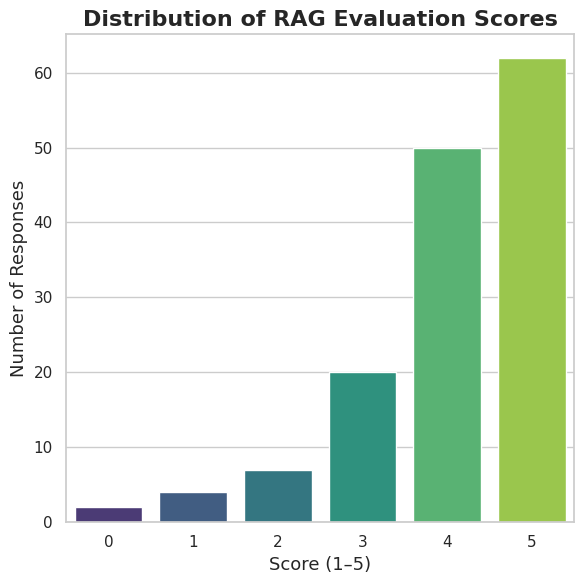

In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# Calculate distribution
score_counts = Counter(scores)
sorted_scores = sorted(score_counts.items())

# Prepare data
x = [str(k) for k, v in sorted_scores]
y = [v for k, v in sorted_scores]

# Set seaborn style
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(x))  # Or try "Set2", "coolwarm"

# Create the plot
plt.figure(figsize=(6, 6))
bars = sns.barplot(x=x, y=y, palette=palette)

# Titles and labels
plt.title("Distribution of RAG Evaluation Scores", fontsize=16, weight='bold')
plt.xlabel("Score (1–5)", fontsize=13)
plt.ylabel("Number of Responses", fontsize=13)
plt.tight_layout()

# Save and show
plt.savefig("rag_evaluation_advanced_chart.png", dpi=300)
plt.show()


In [2]:
pip install sentence-transformers pandas scikit-learn

In [3]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
model = SentenceTransformer("intfloat/multilingual-e5-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
import json
from datasets import Dataset

with open(file, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df = df.rename(columns={
"generated_response": "answer",
"retrieved_context": "context"
})
df = df[["question", "answer", "context"]]
df.to_csv("rag_results.csv", index=False)
question_embeddings = model.encode(df["question"].tolist(), convert_to_tensor=True)
answer_embeddings = model.encode(df["answer"].tolist(), convert_to_tensor=True)
context_embeddings = model.encode(df["context"].tolist(), convert_to_tensor=True)

In [12]:
faithfulness_scores = util.cos_sim(answer_embeddings, context_embeddings).diagonal()
relevance_scores = util.cos_sim(answer_embeddings, question_embeddings).diagonal()

In [13]:
df["faithfulness"] = faithfulness_scores.cpu().numpy()
df["relevance"] = relevance_scores.cpu().numpy()

In [14]:
print("Average Faithfulness Score:", df["faithfulness"].mean())
print("Average Relevance Score:", df["relevance"].mean())

Average Faithfulness Score: 0.91011065
Average Relevance Score: 0.9096691
